# Tâche 3 - Classification automatique de descriptions d'incidents

Cette tâche vise à classifier de courts textes décrivant des incidents qui se sont produits sur des chantiers de construction. Pour chaque incident, on retrouve une étiquette qui correspond au type d’incident (0 à 8). 

Les objectifs de cette tâche sont: 
- de se familiariser avec la classification de texte
- d'apprendre à utiliser les fonctions de base de scikit-learn
- de comprendre comment représenter un texte sous la forme d'un sac de mots (*bag of words*)
- de faire l'évaluation d'un modèle de classification avec un corpus de test
- de tenter d'interpréter les résultats d'un modèle à l'aide des poids d'attributs. 

Pour la première partie, vous devez construire une fonction (*train_and_test_classifier*) qui entraîne un modèle (les options étant la régression logistique et le naïf bayésien) et en faire l'évaluation sur des données d'entraînement et des données de test. Vous devez également évaluer l'impact de la lemmatisation de mots sur la performance des classificateurs. Deux fichiers de textes sont disponibles pour mener votre expérimentation (voir Section 1). 

Pour la deuxième partie, tentez de déterminer à quoi correspond chacune des classes d’incident. Faites une analyse des poids des modèles pour proposer des étiquettes pour chacune des classes. Vous pouvez vous inspirer des notebooks disponibles sur le site du cours. Expliquez clairement comment vous êtes arrivé à vos conclusions. L’important ici est de dégager le thème principal à partir de vos observations et non pas de trouver la formulation exacte des étiquettes. Veuillez noter que certaines classes sont (très) difficiles à identifier. 

Merci de respecter les signatures des fonctions *train_and_test_classifier* et *load_incident_dataset*.

Note sur la lemmatisation: Cette normalisation de texte nécessite l'utilisation d'un modèle qui repose sur l'apprentissage automatique. En conséquence, son temps d'exécution est plus long que le stemming. Si jamais cela ralentit trop vos expérimentations, il est possible de ne faire le traitement qu'une seule fois en sauvegardant les résultats après la première lemmatisation d'un fichier. Cela n'est toutefois pas exigé pour la remise de votre travail et ne sera pas évalué. 

## Section 1 - Lecture des fichiers de données

Voici les fichiers mis à votre disposition pour mener vos expérimentations. La fonction *load_incident_data* peut être utilisée pour lire les 2 fichiers (train et test). Rien à modifier dans cette section. 

In [128]:
import json

train_json_fn = "./data/t3_train.json"
test_json_fn = "./data/t3_test.json"


def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
    return incident_list

In [129]:
train_list = load_incident_dataset(train_json_fn)
print("Nombre d'incidents:", len(train_list))
print("\nUn exemple:\n", train_list[10])

Nombre d'incidents: 2475

Un exemple:
 {'text': " At approximately 12:15 p.m. on February 8  2011  Employee # 1 and four other  coworkers were working in the West storage Facility at Enterprise Products  located at Mont Belvieu  Texas. A major fire began but Employee # 1 wasn't  able to escape. The recovery effort was delayed until the evening of February  10  2011  due to the presence of hydrocarbon vapors and small residual fires.   ", 'label': '6'}


In [130]:
test_list = load_incident_dataset(test_json_fn)
print("Nombre d'incidents", len(test_list))
incident = test_list[10]
print("\nUne description d'incident:", incident["text"])
print("\nSon étiquette:", incident["label"])

Nombre d'incidents 1062

Une description d'incident:  At approximately 2:00 p.m. on March 3  2005  Employee #1  an iron worker  was  performing connecting work at a height of approximately 14 ft above grade.  Employee #1 lost his balance and fell to the ground  landing on his feet. In  order to absorb the impact on his legs from the fall  Employee #1 bent down   striking his head on the spud wrench in the tool belt. He sustained 3 stitches  to his forehead  but he was not hospitalized.                                   

Son étiquette: 5


## Section 2 - Entraînement et évaluation des modèles  

Vous pouvez ajouter tout le code dont vous avez besoin pour l'entraînement. Merci de ne pas modifier la signature de la fonction d'entraînement et de bien expliquer votre démarche et vos résultats. N'oubliez pas de faire une recommandation de modèle. Vous pouvez ajouter des cellules au notebook si nécessaire. 

In [131]:
# Importer ici les librairies dont vous avez besoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import spacy
import time

def train_and_test_classifier(train_fn, test_fn, model='NB', normalization='words'):
    """
    :param train_fn et test_fn: les 2 fichiers utilisées pour entraîner et tester les classificateurs.
    :param model: le type de classificateur. NB = Naive Bayes, LR = Régression logistique.
    :param normalization: la nomralisation appliquée aux mots des descriptions
                 - 'word': les mots des textes sans normalization.
                 - 'lemma': les lemmes des mots obtenus par lemmatisation avec Spacy.
    :return: un dictionnaire contenant 3 datas:
                 - l'accuracy à l'entraînement (validation croisée)
                 - l'accuracy sur le jeu de test
                 - la matrice de confusion calculée par scikit-learn sur les données de test
    """
    start = time.time()
    # Votre code...
    texts = []
    labels = []
    for tmp in train_fn:
        texts.append(tmp["text"])
        labels.append(tmp["label"])
        
    textsTest = []
    labelsTest = []
    for tmp in test_fn:
        textsTest.append(tmp["text"])
        labelsTest.append(tmp["label"])
        
    X_train = texts
    y_train = labels
    X_test = textsTest
    y_test = labelsTest
    
    if normalization == 'words':
        #nothing to do with words normalisation
        pass
    elif normalization == 'lemma':
        X_trainTmp = []
        analyzer_en = spacy.load("en_core_web_sm") 
        for i in range(0, len(X_train)):
            text = X_train[i]
            doc = analyzer_en(text)
            newText = ""
            for token in doc:
                newText += token.lemma_ + " "
            X_trainTmp.append(newText)
        
        X_train = X_trainTmp
    else:
        print("The normalisation : " + normalization + " doesn't exist, use 'words' or 'lemma'.")
        return None
    
    # Le vectorizer permet de convertir les textes en sac de mots (vecteurs de compte)
    vectorizer = CountVectorizer(lowercase=True)
    vectorizer.fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)

    classifier = None
    scores = None
    if(model == 'NB'):
        # On construit un classificateur Naive Bayes sur les données d'entraînement
        # Multinomial = possiblement plusieurs classes
        classifier = MultinomialNB()
        classifier.fit(X_train_vectorized, y_train)
        scores = cross_val_score(classifier, X_train_vectorized, y_train, cv=5)
    elif(model == 'LR'):
        classifier = LogisticRegression(max_iter=1000)
        classifier.fit(X_train_vectorized, y_train)
        scores = cross_val_score(classifier, X_train_vectorized, y_train, cv=5)
    else:
        print("The model : " + model + " is not available, choose LR or NB")
        return None
    
    ##Evaluation de la precission sur les donnée de test
    #Evaluation de l'algorithme sur X_test vectorized et y_test
    X_test_vectorized = vectorizer.transform(X_test)
    y_pred = classifier.predict(X_test_vectorized)
    test_accuracy = accuracy_score(y_test, y_pred)

    # la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Les résultats à retourner
    results = dict()
    results['accuracy_train'] = scores.mean()
    results['accuracy_test'] = test_accuracy
    results['confusion_matrix'] = cm  # la matrice de confusion obtenue de Scikit-learn
    results['execution_time'] = time.time()-start  # le temps d'exécution
    
    return results

In [132]:
models = ['NB', 'LR']
normalizations = ['words', 'lemma']
elements=[]
datas = []

for model in models:
    for normalization in normalizations:
        result = train_and_test_classifier(train_list, test_list, model, normalization)
        if(normalization=="words"):
            print("Résultats pour le modèle {} sans normalisation:".format(model))
            elements.append("Modèle {} sans normalisation".format(model))
        if(normalization=="lemma"):
            print("Résultats pour le modèle {} avec la normalisation {}:".format(model, normalization))
            elements.append("Modèle {} avec la normalisation {}".format(model, normalization))
        
        tmp=[]
        for key, value in result.items():
            if(key=='accuracy_train'):
                tmp.append(value)
            if(key=='accuracy_test'):
                tmp.append(value)
            if key == 'confusion_matrix':
                print("{}:\n{}".format(key, value))
            else:
                print("{}: {}".format(key, value))
        datas.append(tmp)
        print("---------------------------------------------------------")

Résultats pour le modèle NB sans normalisation:
accuracy_train: 0.6921212121212121
accuracy_test: 0.7090395480225988
confusion_matrix:
[[129   0   0   0   0  37   0  15   9]
 [  4   0   0   0   0   3   0   3   0]
 [  0   0 117   0   0   7   0   0   0]
 [  5   0   1   5   0   6   0   8   2]
 [  0   0   1   0   0   2   0   3   0]
 [ 17   0   4   0   0 375   0   3   2]
 [  2   0  10   0   0   7  21  11   0]
 [ 28   0  10   1   0  23   0  62   6]
 [ 29   0   1   0   0  41   1   7  44]]
execution_time: 0.49887800216674805
---------------------------------------------------------
Résultats pour le modèle NB avec la normalisation lemma:
accuracy_train: 0.694949494949495
accuracy_test: 0.6902071563088512
confusion_matrix:
[[126   0   0   0   0  34   0  17  13]
 [  4   0   1   0   0   0   0   3   2]
 [  2   0 112   0   0   9   0   0   1]
 [  3   0   3   8   0   4   0   6   3]
 [  0   0   1   0   0   1   0   4   0]
 [ 18   0   5   0   0 355   0   9  14]
 [  3   0  10   0   0  10  19   9   0]
 [ 

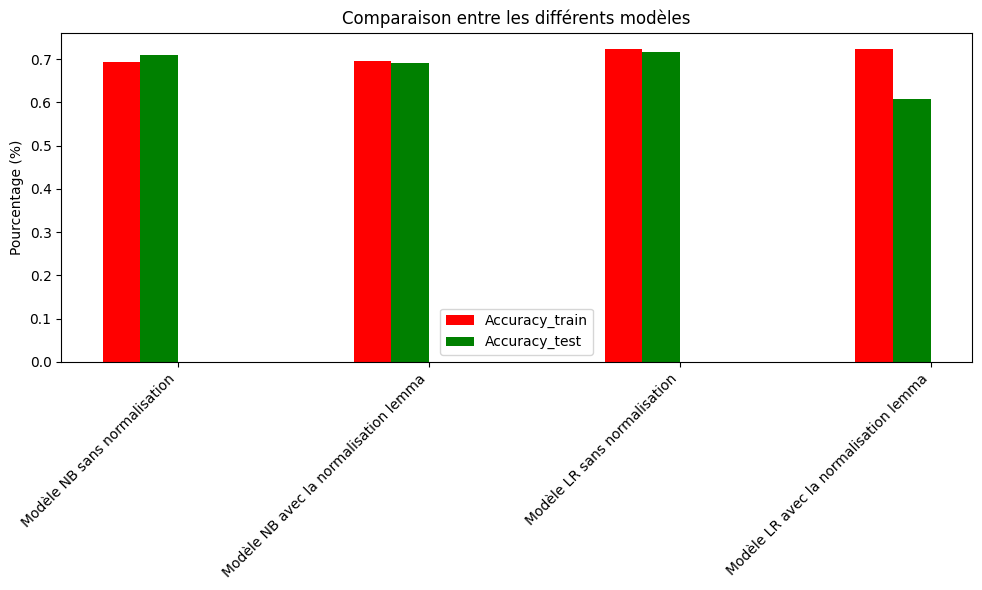

In [133]:
import matplotlib.pyplot as plt
import numpy as np

internals = ['Accuracy_train', 'Accuracy_test']
values = np.array(datas)


colors = ['r', 'g', 'b']


bar_width = 0.15


fig, ax = plt.subplots(figsize=(10, 6))


for i in range(len(internals)):
    x = np.arange(len(elements))
    y = values[:, i]
    ax.bar(x + i * bar_width, y, width=bar_width, label=internals[i], color=colors[i])

ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(elements, rotation=45, ha="right")

ax.set_ylabel('Pourcentage (%)')
ax.set_title('Comparaison entre les différents modèles')
ax.set_xticks(x + bar_width * 1.5)
ax.set_xticklabels(elements)
ax.legend()

plt.tight_layout()
plt.show()


# Analyse des Résultats

## Précision (Accuracy)

## Régression Logistique vs. Naïf Bayésien
    La régression logistique (LR) affiche une précision nettement supérieure à celle du Naïf Bayésien (NB), tant pour les données d'entraînement que pour celles de test. En particulier, sans la normalisation , le modèle LR atteint une précision de test de 71.75%, contre 70.90% pour le modèle NB. 

## Impact de la Lemmatisation
    La lemmatisation semble avoir un impact négatif sur la précision de classification pour les deux modèles. Par exemple, pour le modèle NB, la précision de test diminue de 70.90% à 69.02% avec la lemmatisation. Ce sera la même chose, pour le modèle LR, il passe de 71.75% à 60.73%.

## Temps d'exécution

## Régression Logistique vs. Naïf Bayésien
    Les modèles de régression logistique (LR) prennent nettement plus de temps à s'exécuter que les modèles Naïf Bayésien (NB). Pour LR, le temps d'entraînement et le test atteint 36.49 secondes sans lemmatisation, contre seulement 0.36 seconde pour NB sans lemmatisation.

## Impact de la Lemmatisation
    La lemmatisation ajoute du temps au processus de prétraitement, ce qui est attendu car elle nécessite une analyse morphologique des mots. 


In [134]:
#on affiche les incidents par étiquette
incidents = [
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    []
]

for incident in test_list:
    incidents[int(incident['label'])].append(incident['text'])


In [135]:
#on affiche les incident par étiquette:
max_sentence = 10

for i in range(0, 9):
    print("\n\n")
    print("Label " + str(i) + " : ")
    for j in range(0, len(incidents[i])):
        print(incidents[i][j])
        if j > max_sentence:
            break
        




Label 0 : 
 On September 24  2001  Employee #1  a grading superintendent of Everett Dykes  Grassing Company  Inc. was crossing a roadway to prepare for the delivery of  pipe. As the Employee #1 entered the roadway  he began speaking to another  employee walking along the side of the road. Before a verbal warning could be  conveyed  Employee #1 was struck by an oncoming fuel truck. Employee #1 died  from the injuries he sustained. Employee #1 was not wearing a reflective vest.  
 On January 25  2012  Employee#1 and Employee #2 were on the first level of the  one story wooden structure when it collapsed. Employee #1 was able to crawl  out from underneath the fallen structure and received out-patient medical care  for minor injuries. Employee # 2 died at the scene.                             
 On December 1  2010  Employee #1 painted a four story condominium complex. The  first floor of the complex was an open area designed for resident parking.  Employee #1 operated a JLG model 600S 

## Section 3 - À quoi correspondent les classes? Explicabilité du modèle

En utilisant les poids des modèles, tentez d'attribuer une signification aux différentes classes. Comme c'est une épreuve d'analyse de données, il est possible que certaines classes ne soient pas interprétables. Vous n'êtes pas tenu à l'impossible. L'important est d'utiliser ce qu'on observe dans les modèles pour fournir une explication.

Vous pouvez ajouter tout le code et toutes les cellules dont vous avez besoin.

## Section 4 - Section réservée pour nos tests (ne pas modifier)